In [1]:
### Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast, json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data collected during deployement

The dployed model received, classified and and stored observation for a period of one week. Let's look at that data and how the model performed.

In [2]:
###Load Data

# Load deploy data 
path = 'Data/DeployData.csv'
train_df = pd.read_csv(path)

# Unpack observations dicts
obs = pd.DataFrame()
for row in train_df.observation:
    obs = obs.append(pd.DataFrame.from_dict(json.loads(row.split('observation:')[0])['observation'],
                                            orient='index').transpose())
    
## Join DataFrames
obs_df = obs.reset_index(drop=True)
deploy_df = obs_df.join(train_df[['observation_id','pred','true_class']]).set_index('observation_id',drop=True)
deploy_df.head()

,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator,VehicleSearchedIndicator,pred,true_class
observation_id,,,,,,,,,,,,,,,,
7669,Vernon,08/12/2018 12:13:00 AM,VERNON,V,626,True,C,Moving Violation,23.0,N,B,M,False,NaN,True,NaN
492,Groton Town,05/22/2018 10:00:00 AM,GROTON,I,NORDB,False,O,Other,46.0,N,W,F,False,NaN,True,0.0
493,Groton Town,05/22/2018 10:00:00 AM,GROTON,I,NORDB,False,O,Other,46.0,N,W,F,False,NaN,True,0.0
494,Trumbull,05/22/2018 10:26:00 AM,Trumbull,V,5110,True,O,Other,25.0,N,B,M,False,NaN,True,1.0
495,Trumbull,05/22/2018 10:26:00 AM,Trumbull,V,5110,True,O,Other,25.0,N,B,M,False,NaN,True,1.0


Just a look at the first observations of the data set shows two pairs of repeated observations, observation_id 492-493 and 494-495, and an observation with a null true label observation_id 7669. Let's see how generalised are these problems. 

During deployment 10000 observations were collected, from those 5017 were repetitions,leaving 4983 unique observations.
From the unique observations 2491 have null true label values, leaving us with 2492 observations for which we the true label.


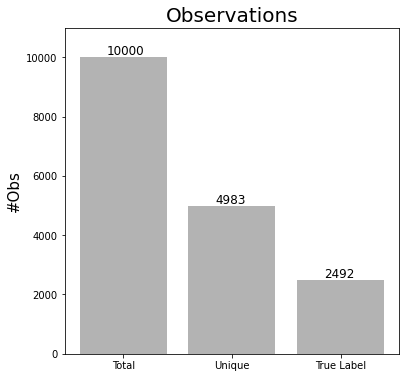

In [3]:
### First look into the data

## Get info to plot
t_obs = deploy_df.shape[0]
un_obs = deploy_df[~deploy_df.iloc[:,1:].duplicated()].shape[0]
val_obs = deploy_df.loc[~deploy_df.iloc[:,1:].duplicated(),'true_class'].isnull().sum()


## Plot

#define fig and subplots
fig,axs = plt.subplots(1, 1, figsize=(6,6))

#plots font sizes
l_font = 15
t_font = 20
txt_font = 12

vals = [t_obs, un_obs, val_obs]
axs.bar(['Total', 'Unique', 'True Label'],vals,color=['#B3B3B3'])
axs.set_ylabel('#Obs',fontsize = l_font)
axs.set_title('Observations',fontsize = t_font)
axs.set_ylim([0, 11000])
#axs[0].set_xlim([-0.75, 1.75])

for i, v in enumerate(vals): # place values on top of bars
    axs.text(i - 0.15, v + 100, str(np.round(v,2)),fontsize = txt_font)
    
    
output = (f'During deployment {t_obs} observations were collected, from those {t_obs - un_obs} were repetitions,'
          f'leaving {un_obs} unique observations.\n'
          f'From the unique observations {un_obs - val_obs} have null true label values, leaving us with {val_obs} '
          f'observations for which we the true label.')
print(output)
    

So before proceding with the analysis we have to clean the data set to leave just the unique observations for which we know the true label.

Also, for the following analysis we don't need all the features' columns so we are also going to drop those and change the name of the remainings. 

## Filter data set

In [4]:
### Clean DataSet

#discard repeated observations
deploy_df = deploy_df.loc[~deploy_df.iloc[:,1:].duplicated(),:]

#discard null true_id observations
deploy_df = deploy_df[~deploy_df['true_class'].isnull()]

#keep just columns of interest
deploy_df = deploy_df[['Department Name','SubjectRaceCode','SubjectEthnicityCode','SubjectSexCode','pred','true_class']]

#change column names 
names_map = {'SubjectRaceCode':'Subject Race Code',
             'SubjectSexCode':'Subject Sex Code',
             'SubjectEthnicityCode':'Subject Ethnicity Code',
             'pred':'Preds',
             'true_class':'True_Id'}

deploy_df = deploy_df.rename(columns = names_map)
deploy_df['True_Id'] = deploy_df['True_Id'].astype(bool)

deploy_df.head()

,Department Name,Subject Race Code,Subject Ethnicity Code,Subject Sex Code,Preds,True_Id
observation_id,,,,,,
492,Groton Town,W,N,F,True,False
494,Trumbull,B,N,M,True,True
496,East Hartford,W,H,M,True,False
2588,Middletown,W,H,M,True,False
2590,Danbury,B,N,F,False,False


# Model Performance

We tested the model in held out data during development which gave us an idea of what to expect in a real world scenario. We can now confirm the validity of those expectations.  

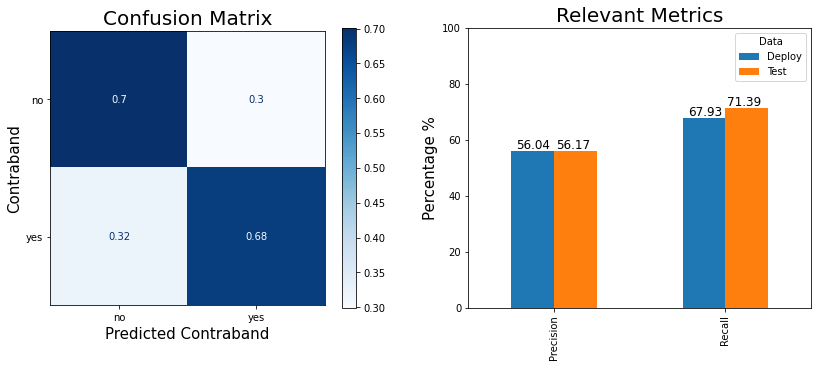

In [5]:
### Calculate and plot model performance

## Calculate Performance metrics

#confusion matrix
conf_mat = confusion_matrix(deploy_df['True_Id'], deploy_df['Preds'])

hits = conf_mat[1,1] # Contrabands correctly predicted
positives = conf_mat[1].sum() # Contrabands on the real data 

f_alarms = conf_mat[0,1] # Contrabands incorrectly predicted
negatives = conf_mat[0].sum() # Non contrabands on real the data


#precision-recall
d_precision = hits / (hits + f_alarms) * 100
d_recall = hits / positives * 100


#precision recall on the model test data for comparison
t_precision = 56.17
t_recall = 71.39


## Plot model performance

#define fig and subplots
fig,axs = plt.subplots(1, 2, figsize=(12,6))

#plots font sizes
l_font = 15
t_font = 20
txt_font = 12


# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(deploy_df['True_Id'],deploy_df['Preds'],
                                        ax=axs[0],
                                        display_labels=["no", "yes"],
                                        normalize='true',
                                        cmap='Blues')

axs[0].set_title('Confusion Matrix',fontsize = t_font)
axs[0].set_xlabel('Predicted Contraband',fontsize = l_font)
axs[0].set_ylabel('Contraband',fontsize = l_font)



perf_df = pd.DataFrame([['Precision','Test',t_precision],['Precision','Deploy',d_precision],
                   ['Recall','Test',t_recall],['Recall','Deploy',d_recall]],
                    columns=['Metric','Data','Val'])

#plot precision and recall 
perf_df.pivot("Metric","Data","Val").plot(kind='bar',ax=axs[1])
axs[1].set_ylabel('Percentage %',fontsize = l_font)
axs[1].set_xlabel(' ',fontsize = l_font)
axs[1].set_title('Relevant Metrics',fontsize = t_font)
axs[1].set_ylim([0, 100])


for i, v in enumerate([d_precision,d_recall]): # place values on top of bars
    axs[1].text(i - 0.22, v + 0.8, str(np.round(v,2)),fontsize = txt_font)

for i, v in enumerate([t_precision,t_recall]): # place values on top of bars
    axs[1].text(i + 0.01, v + 0.8, str(np.round(v,2)),fontsize = txt_font)
    
    
      
fig.tight_layout(pad=3.0)

plt.show()    

## Performance Results

Looking at the confusion matrix (left plot) we can see that our model correctly classifies 0.68 of the contraband observations (True Positives) and 0.7 of the ones with no contraband (True Negatives). This is very much in line with the results obtained during model development.

The same is true for precision and recall (right plot) where again the results in real world data are very similar to the one obtained during model development. *More importantly this also means that the precision and recall results satisfy the initial requirement of being at least 50%*.  


# Model Fairness

Our model fulfilled the clients' performance requirements in the observations collected during deployment. We already know, from the results obtained during development, that the fairness objectives, particularly the ones concerning individual departments, are more difficult or even impossible to acomplish. The fact that we don't have that many observations from deployement, making the results more noisy, is not a good indicator that we will be able to do better in that front, but let's look at the actual results.  



## General fairness

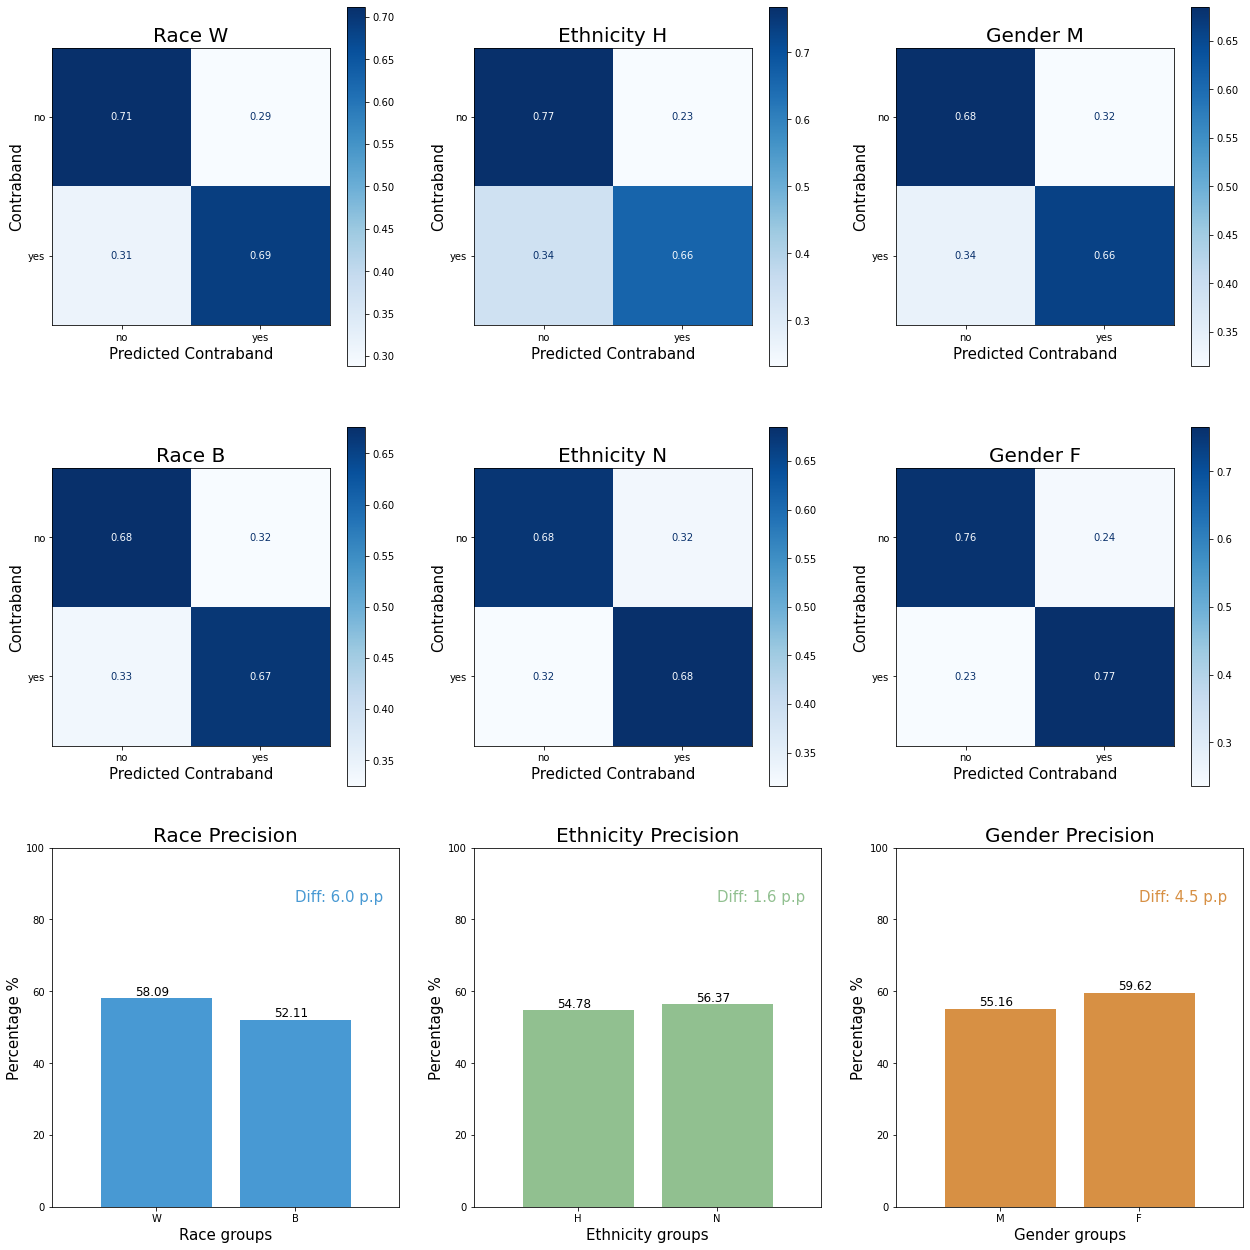

In [6]:
### General bias analysis

## Calculate and organize data to plot

#race bias df
races = ['W','B']
r_dict = {}
for r in races:
    r_dict[r] = {}
    f = deploy_df['Subject Race Code'] == r
    r_dict[r]['df'] = deploy_df.loc[f,['Subject Race Code','Preds','True_Id']]
    conf_mat = confusion_matrix(r_dict[r]['df']['True_Id'], r_dict[r]['df']['Preds'])
    r_dict[r]['hits'] = conf_mat[1,1]
    r_dict[r]['pos'] = conf_mat[1].sum() 
    r_dict[r]['fa'] = conf_mat[0,1] 
    r_dict[r]['neg'] = conf_mat[0].sum()
    r_dict[r]['precision'] = r_dict[r]['hits'] /(r_dict[r]['hits'] + r_dict[r]['fa'])
    
    
#ethnicity bias df
ethnicities = ['H','N']
e_dict = {}
for e in ethnicities:
    e_dict[e] = {}
    f = deploy_df['Subject Ethnicity Code'] == e
    e_dict[e]['df'] = deploy_df.loc[f,['Subject Ethnicity Code','Preds','True_Id']]
    conf_mat = confusion_matrix(e_dict[e]['df']['True_Id'],e_dict[e]['df']['Preds'])
    e_dict[e]['hits'] = conf_mat[1,1]
    e_dict[e]['pos'] = conf_mat[1].sum() 
    e_dict[e]['fa'] = conf_mat[0,1] 
    e_dict[e]['neg'] = conf_mat[0].sum()
    e_dict[e]['precision'] = e_dict[e]['hits'] /(e_dict[e]['hits'] + e_dict[e]['fa'])
    
    
    
#gender bias df
genders = ['M','F']
g_dict = {}
for g in genders:
    g_dict[g] = {}
    f = deploy_df['Subject Sex Code'] == g
    g_dict[g]['df'] = deploy_df.loc[f,['Subject Sex Code','Preds','True_Id']]
    conf_mat = confusion_matrix(g_dict[g]['df']['True_Id'], g_dict[g]['df']['Preds'])
    g_dict[g]['hits'] = conf_mat[1,1]
    g_dict[g]['pos'] = conf_mat[1].sum() 
    g_dict[g]['fa'] = conf_mat[0,1] 
    g_dict[g]['neg'] = conf_mat[0].sum()
    g_dict[g]['precision'] = g_dict[g]['hits'] /(g_dict[g]['hits'] + g_dict[g]['fa'])    



## Plot general bias data 

#define fig and subplots
fig,axs = plt.subplots(3, 3, figsize=(18,18))

# plots font sizes
l_font = 15
t_font = 20
txt_font = 12



## Plot confusion matrice 

dicts = [r_dict,e_dict,g_dict] # data to plot

#subplot initial indices
cx = 0
rx = 0

p_groups = ['Race','Ethnicity','Gender'] # plots labels
g_clrs = ['#4899D3','#91C090','#D79044'] # plots colors

for d in dicts:
    #plot confusion matrices
    for r in d.keys():
        
        ConfusionMatrixDisplay.from_predictions(d[r]['df']['True_Id'],d[r]['df']['Preds'],
                                                ax=axs[rx,cx],
                                                display_labels=["no", "yes"],
                                                normalize='true',
                                                cmap='Blues',
                                                colorbar = True)
      
        axs[rx,cx].set_title(p_groups[cx]+' '+ r,fontsize = t_font)
        axs[rx,cx].set_xlabel('Predicted Contraband',fontsize = l_font)
        axs[rx,cx].set_ylabel('Contraband',fontsize = l_font)
        
        #update subplot indices
        if rx == 0:
            rx = 1
        else:
            rx = 0
    
    
    #plot precisions
    g_labels = list(d.keys())
    y1 = [d[g_labels[0]]['precision']*100, d[g_labels[1]]['precision']*100]
    pp_diff = np.round(np.abs(d[g_labels[0]]['precision']*100 - d[g_labels[1]]['precision']*100),1)
    axs[2,cx].bar([g_labels[0], g_labels[1]],y1,color=g_clrs[cx])
    axs[2,cx].text(1, 85, 'Diff: '+str(pp_diff)+' p.p',fontsize = l_font,color=g_clrs[cx])
    axs[2,cx].set_xlabel(p_groups[cx]+' '+'groups',fontsize = l_font)
    axs[2,cx].set_ylabel('Percentage %',fontsize = l_font)
    axs[2,cx].set_title(p_groups[cx]+' '+ 'Precision',fontsize = t_font)
    axs[2,cx].set_ylim([0, 100])
    axs[2,cx].set_xlim([-0.75, 1.75])
          
    for i, v in enumerate(y1): # place values on top of bars
        axs[2,cx].text(i - 0.15, v + 0.8, str(np.round(v,2)),fontsize = txt_font)
    
    
    cx = cx+1


    
fig.tight_layout(pad=3.0)       
plt.show()



## General fairness results

The confusion matrices shows us that the results of the model are qualitatively consistent across the different groups of the protected classes and also with the overall results presented above.

From the three protected groups only in race the different in precision between the two different groups excedes the 5 p.p. that was our objective, and not by 1 p.p. . Both it the ethnicity and gender classes the differences are within the desired margin.

## Fairness by department

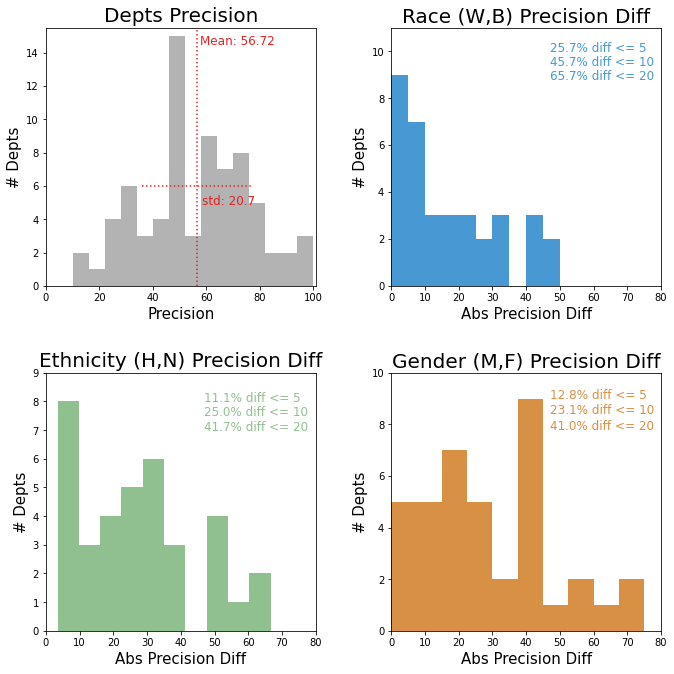

In [7]:
### Calculate and plot precision differences by department


## Calculations

#Get dept names 
obs_dpt = deploy_df['Department Name'].value_counts()
dpt_names = obs_dpt.keys().tolist()

#Only include depts wit #obs above this treshold
obs_tresh = 5

#Df's to store the data
r_precision = pd.DataFrame()
e_precision = pd.DataFrame()
g_precision = pd.DataFrame()
t_precision = pd.DataFrame()

#For each department
for dpt in dpt_names:
    
    #precision per dept
    t_f = deploy_df['Department Name'] == dpt
    t_df = deploy_df.loc[t_f,['Preds','True_Id']]
    conf_mat = confusion_matrix(t_df['True_Id'],t_df['Preds'])
    if t_df.shape[0] >= obs_tresh and conf_mat.shape != (1,1):
        t_hits = conf_mat[1,1]
        t_pos = conf_mat[1].sum() 
        t_fa = conf_mat[0,1]
        if t_hits != 0:
            t_precision.loc[dpt,'total'] = (t_hits /(t_hits + t_fa))*100
        else:
            t_precision.loc[dpt,g] = 0

    
    
    #race precision per dept
    for r in ['W','B']:
        r_f = (deploy_df['Department Name'] == dpt) & (deploy_df['Subject Race Code'] == r)
        r_df = deploy_df.loc[r_f,['Preds','True_Id']]
        conf_mat = confusion_matrix(r_df['True_Id'],r_df['Preds'])
        if r_df.shape[0] >= obs_tresh and conf_mat.shape != (1,1):
            r_hits = conf_mat[1,1]
            r_pos = conf_mat[1].sum() 
            r_fa = conf_mat[0,1]
            if r_hits != 0: 
                r_precision.loc[dpt,r] = (r_hits /(r_hits + r_fa))*100
    
    if r_precision.shape[1] >= 2:   
        r_precision['diff'] = np.abs(r_precision['W'] - r_precision['B'])
    
    #ethnicity precision per dept
    for e in ['H','N']:
        e_f = (deploy_df['Department Name'] == dpt) & (deploy_df['Subject Ethnicity Code'] == e)
        e_df = deploy_df.loc[e_f,['Preds','True_Id']]
        conf_mat = confusion_matrix(e_df['True_Id'],e_df['Preds'])
        if e_df.shape[0] >= obs_tresh and conf_mat.shape != (1, 1):
            e_hits = conf_mat[1,1]
            e_pos = conf_mat[1].sum() 
            e_fa = conf_mat[0,1]
            if e_hits != 0:
                e_precision.loc[dpt,e] = (e_hits /(e_hits + e_fa))*100
            else:
                e_precision.loc[dpt,e] = 0
    
    if e_precision.shape[1] >= 2: 
        e_precision['diff'] = np.abs(e_precision['H'] - e_precision['N'])
    
    
    #gender precision per dept
    for g in ['M','F']:
        g_f = (deploy_df['Department Name'] == dpt) & (deploy_df['Subject Sex Code'] == g)
        g_df = deploy_df.loc[g_f,['Preds','True_Id']]
        conf_mat = confusion_matrix(g_df['True_Id'],g_df['Preds'])
        if g_df.shape[0] >= obs_tresh and conf_mat.shape != (1, 1):
            e_hits = conf_mat[1,1]
            g_hits = conf_mat[1,1]
            g_pos = conf_mat[1].sum() 
            g_fa = conf_mat[0,1]
            if g_hits != 0:
                g_precision.loc[dpt,g] = (g_hits /(g_hits + g_fa))*100
            else:
                g_precision.loc[dpt,g] = 0
    
    if g_precision.shape[1] >= 2: 
        g_precision['diff'] = np.abs(g_precision['M'] - g_precision['F'])


    
## Plot precision differences in protected classes
    
#define fig and subplots
fig,axs = plt.subplots(2, 2, figsize=(10,10))

#plots font sizes
l_font = 15
t_font = 20
txt_font = 12


#plot precision per department
axs[0,0].hist(t_precision['total'],bins = 15, color=['#B3B3B3'])
tp_mean = t_precision['total'].mean()
tp_std = t_precision['total'].std()
axs[0,0].plot([tp_mean, tp_mean], [0, 15.5], linestyle=':', color =  '#E52123')
axs[0,0].plot([tp_mean - tp_std, tp_mean + tp_std], [6, 6], linestyle=':', color =  '#E52123')

axs[0,0].text(t_precision['total'].mean()+1, 14.5,
              'Mean: '+str(np.round(t_precision['total'].mean(),2)),
              fontsize = txt_font,
              color =  '#E52123')

axs[0,0].text(tp_mean+1.7, 4.9,
              'std: '+str(np.round(tp_std,2)),
              fontsize = txt_font,
              color =  '#E52123')

axs[0,0].set_ylabel('# Depts',fontsize = l_font)
axs[0,0].set_xlabel('Precision',fontsize = l_font)
axs[0,0].set_title('Depts Precision',fontsize = t_font)
axs[0,0].set_ylim([0, 15.5])
axs[0,0].set_xlim([0, 101])






#Plot race differences
axs[0,1].hist(r_precision['diff'],bins = 10, color=['#4899D3'])

sub = 0
for t in [5,10,20]:
    valid_df = r_precision.dropna().copy()
    val = np.round(valid_df.loc[valid_df['diff']<=t,'diff'].shape[0] / valid_df.shape[0]*100,1)
    axs[0,1].text(47, 10-sub,
              str(val)+'% diff <= '+ str(t),
              fontsize = txt_font,
              color =  '#4899D3')
    sub = sub+0.6
    
axs[0,1].set_ylabel('# Depts',fontsize = l_font)
axs[0,1].set_xlabel('Abs Precision Diff',fontsize = l_font)
axs[0,1].set_title('Race (W,B) Precision Diff',fontsize = t_font)
axs[0,1].set_ylim([0, 11])
axs[0,1].set_xlim([0, 80])



#plot ethnicity differences
axs[1,0].hist(e_precision['diff'],bins = 10, color=['#91C090'])

sub = 0
for t in [5,10,20]:
    valid_df = e_precision.dropna().copy()
    val = np.round(valid_df.loc[valid_df['diff']<=t,'diff'].shape[0] / valid_df.shape[0]*100,1)
    axs[1,0].text(47, 8-sub,
              str(val)+'% diff <= '+ str(t),
              fontsize = txt_font,
              color =  '#91C090')
    sub = sub+0.5
    
axs[1,0].set_ylabel('# Depts',fontsize = l_font)
axs[1,0].set_xlabel('Abs Precision Diff',fontsize = l_font)
axs[1,0].set_title('Ethnicity (H,N) Precision Diff',fontsize = t_font)
axs[1,0].set_ylim([0, 9])
axs[1,0].set_xlim([0, 80])


#plot gender differences
axs[1,1].hist(g_precision['diff'],bins = 10, color=['#D79044'])

sub = 0
for t in [5,10,20]:
    valid_df = g_precision.dropna().copy()
    val = np.round(valid_df.loc[valid_df['diff']<=t,'diff'].shape[0] / valid_df.shape[0]*100,1)
    axs[1,1].text(47, 9-sub,
              str(val)+'% diff <= '+ str(t),
              fontsize = txt_font,
              color =  '#D79044')
    sub = sub+0.6
    
axs[1,1].set_ylabel('# Depts',fontsize = l_font)
axs[1,1].set_xlabel('Abs Precision Diff',fontsize = l_font)
axs[1,1].set_title('Gender (M,F) Precision Diff',fontsize = t_font)
axs[1,1].set_ylim([0, 10])
axs[1,1].set_xlim([0, 80])


fig.tight_layout(pad=3.0)       
plt.show()




## Fairness by department results

As in the model development phase there's a fair degree of variability in the overal precision observed in each department. The mean precision is very similar to previously observed with the distribution being slightly wider: 20.7 vs 15.08 standard deviation. 


The low number of observations collected, and their segmentation across sub-departments -> protected classes -> protected classes group made the sub-department specific fairness analysis very noisy and the comparison with the training results very difficult to perform in a meaningful way.

With this limiation in mind, it's clear that the objective of having the precision associated  with the groups in each protected class within a 5 p.p. difference margin was clearly not met.   

We didn't include in this analysis departments with less than 5 observations.  


# Final Observations 

The original police department requirements were: a success rate above 50% in all searches, to apprehend as much contraband as possible and to have a success rate difference, between protected groups, within 5 p.p. in all sub-departments.

Based on such requirements, and as documented in the *Model Development* notebook, we created a search authorization assistance that caught 71.93% of the existent contraband (recall) and was successful in more than half of the searches (precision - 56.17%). The results during deployment were consistent with these:  **a precision of 56.04%** and **a recall of 67.93%**. 

By following our recommendations the police department was able to find contraband in more than half of the performed searches, a significant increase from the original, non-assisted, 30% of searches with contraband found. Such an improvement represents savings in resources and agents’ time, but also means that less citizens are unjustifiably searched.

The precision of the model in observations from the groups of each protected class (race, ethnicity, gender) is very much within the 5 p.p. difference initially established, the exception being race but only by 1 p.p. . Nevertheless the requirement was to have this difference in each department which clearly was not possible. 


# Future Plans

The first implementation of the search authorization advice system, developed per request of the police, was quite successful in terms of improving the department search policy efficiency. Our model helped police officers in apprehending a good amount of contraband with less disruptive searches.

The biggest room for improvement relates to the fairness of the model, also a requirement of the department. At current state the dataset made available to us is too unbalanced and contains too many biases, making it very hard to get fair predictions from a model developed from it: as it was evident from the development process and deployment period detailed in this and the previous report. After all a model can only learn the patterns present in the data it is fed with.

One possible immediate solution could be to train a model that specifically optimizes a custom score metric based on fairness. It’s unclear what effects this could have in the global results of the model - concerning the amount of contraband apprehended and the searches success rate - but we think that it’s something worth trying. Ultimately it would be up for the department to decide what requirement or requirements to prioritize.

There’s a point in which there is only as much one can do with a given dataset. We think that the way forward is dependent on a closer collaboration between us and the police department. Following what was learned from our work with this dataset police officers could be informed of the biases in which they are naturally incurring and little by little, in an iterative process, an improved dataset could be built. Taking advantage of this new dataset(s) our model could be progressively improved to produce fairer recommendations. With a fairer base dataset more effective, even if less interpretable, models could be used with diminished risk.

We also think that the way the service is implemented, with us providing a search go , or no go, authorization is poor. Our models can uncover patterns that are not accessible to the officers, but ultimately they are the ones in the streets making the decisions at every moment. Given the information we possess we feel that our service would have broader and more positive outcomes if for every observation we could provide more information. For instance, we think that providing the officers with a probability of contraband (instead of the prediction itself) and with a flag marking observations with a high bias risk, could empower them to use our service as an aid to their decision process instead of as a replacement of it. Informed officers, in the possession of relevant information, could make more informed and conscious decisions than officers which are just told how to proceed.

All the above observations and suggestions demand for a continuous, iterative and integrated collaboration between us and the police department, resulting in a constant monitoring and improvement of the service.